In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:06<00:00, 27636429.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import torchvision.models as models

# Load a pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes in CIFAR-10
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


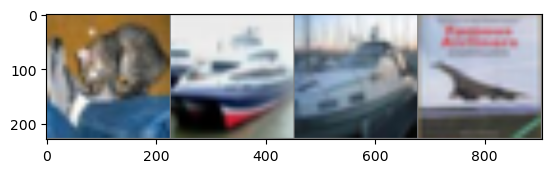

  cat  ship  ship plane


In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [5]:
# Select a layer for which you want to visualize the activation maps
layer_name = 'layer1'

# Create a forward hook
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hook
resnet50.layer1[0].conv1.register_forward_hook(get_activation('layer1_conv1'))


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


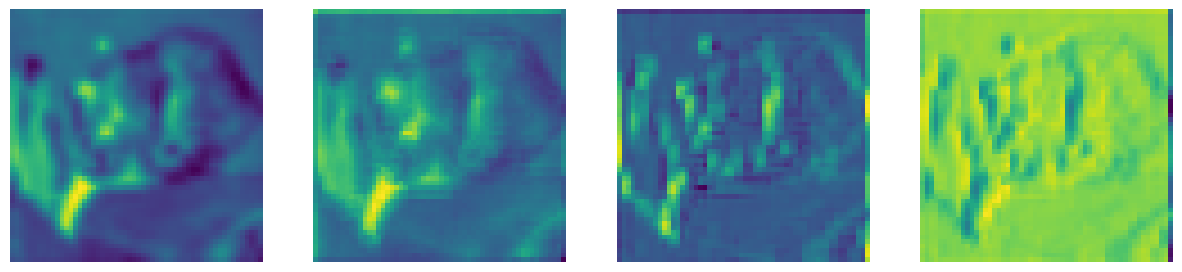

In [6]:
# Put the model in evaluation mode
resnet50.eval()

# Move model and input to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)
images = images.to(device)

# Forward pass through the network
output = resnet50(images)

# Get the activation maps from the selected layer
act = activation['layer1_conv1'].cpu()

# Plot the activation maps
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for idx in range(4):
    axs[idx].imshow(act[0, idx].numpy(), cmap='viridis')
    axs[idx].axis('off')

plt.show()


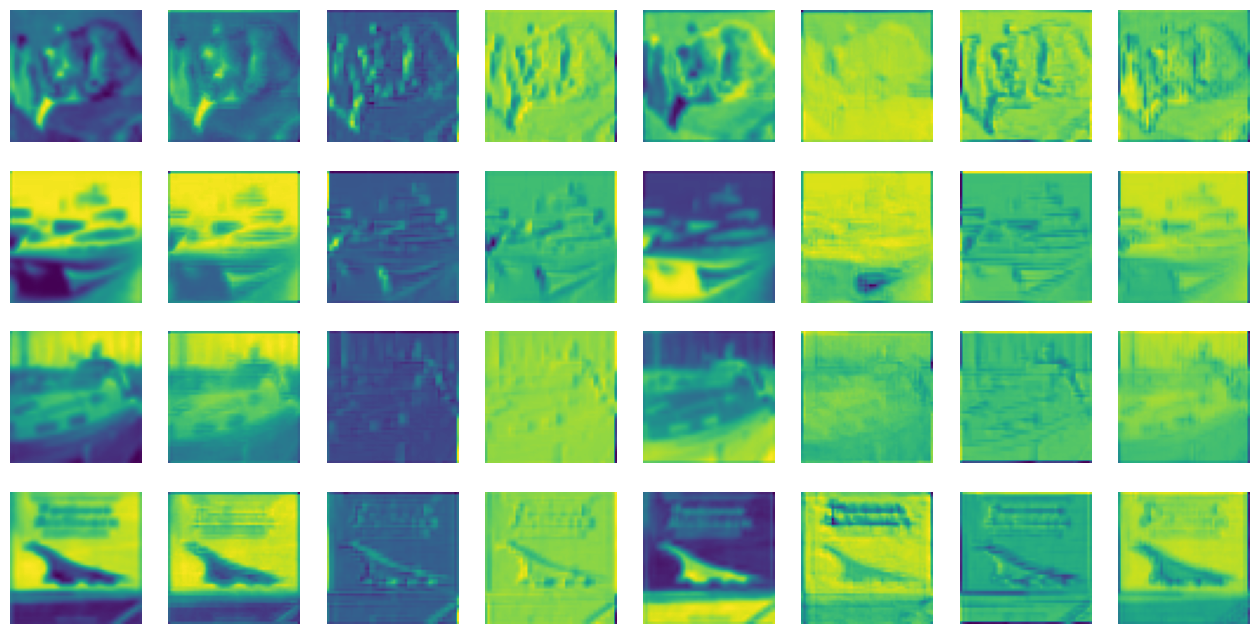

In [7]:
# Define a function to plot activation maps
def plot_activation_maps(activation, num_images=4, num_maps=8):
    fig, axes = plt.subplots(num_images, num_maps, figsize=(num_maps * 2, num_images * 2))
    for img_idx in range(num_images):
        for map_idx in range(num_maps):
            axes[img_idx, map_idx].imshow(activation[img_idx, map_idx].cpu().numpy(), cmap='viridis')
            axes[img_idx, map_idx].axis('off')
    plt.show()

# Set the number of images and feature maps to visualize
num_images_to_visualize = 4
num_feature_maps_to_visualize = 8

# Get the activation maps from the selected layer
activation_maps = activation['layer1_conv1']

# Plot the activation maps
plot_activation_maps(activation_maps, num_images=num_images_to_visualize, num_maps=num_feature_maps_to_visualize)


Plot activation maps for layer2


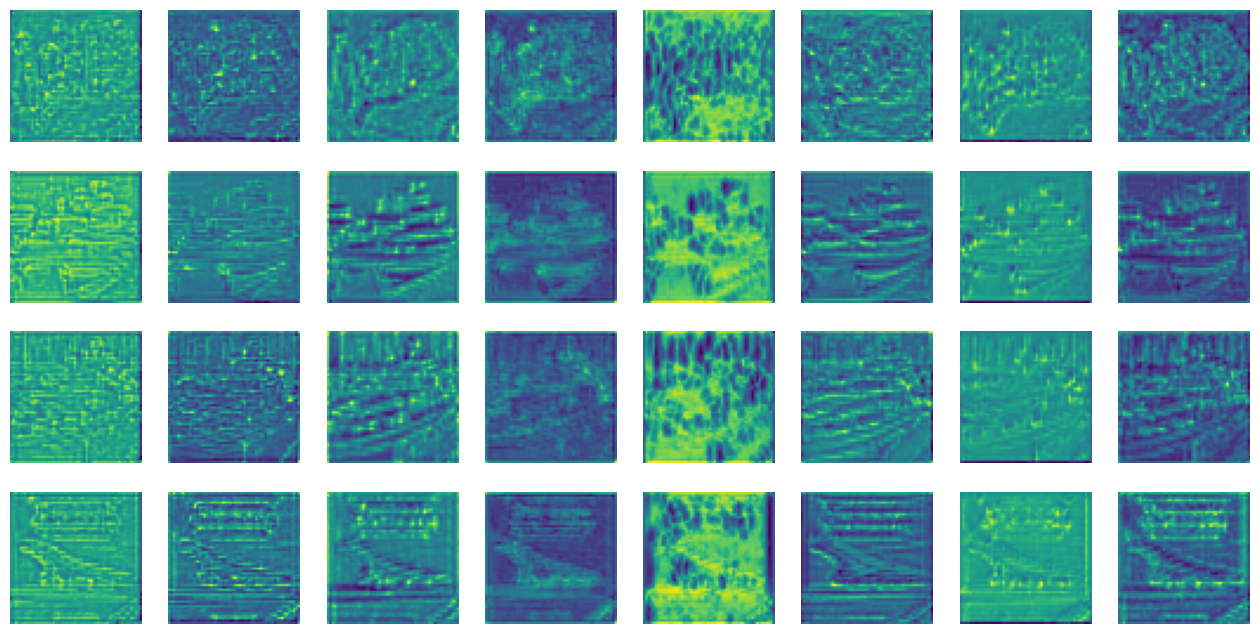

Plot activation maps for layer3


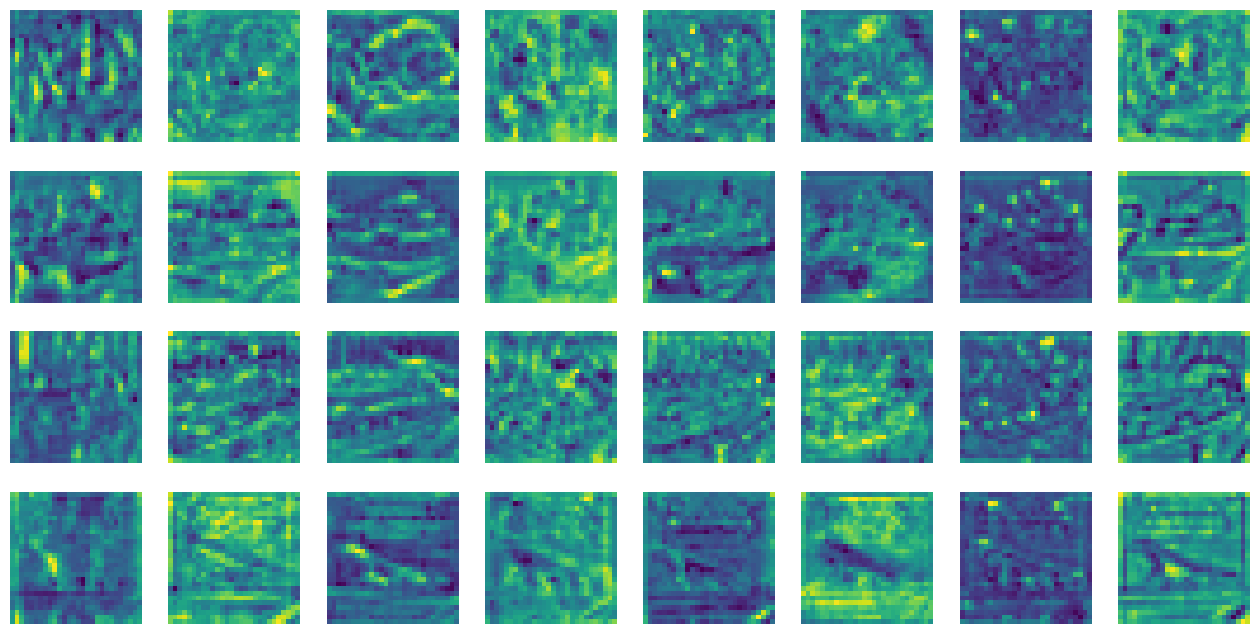

Plot activation maps for layer4


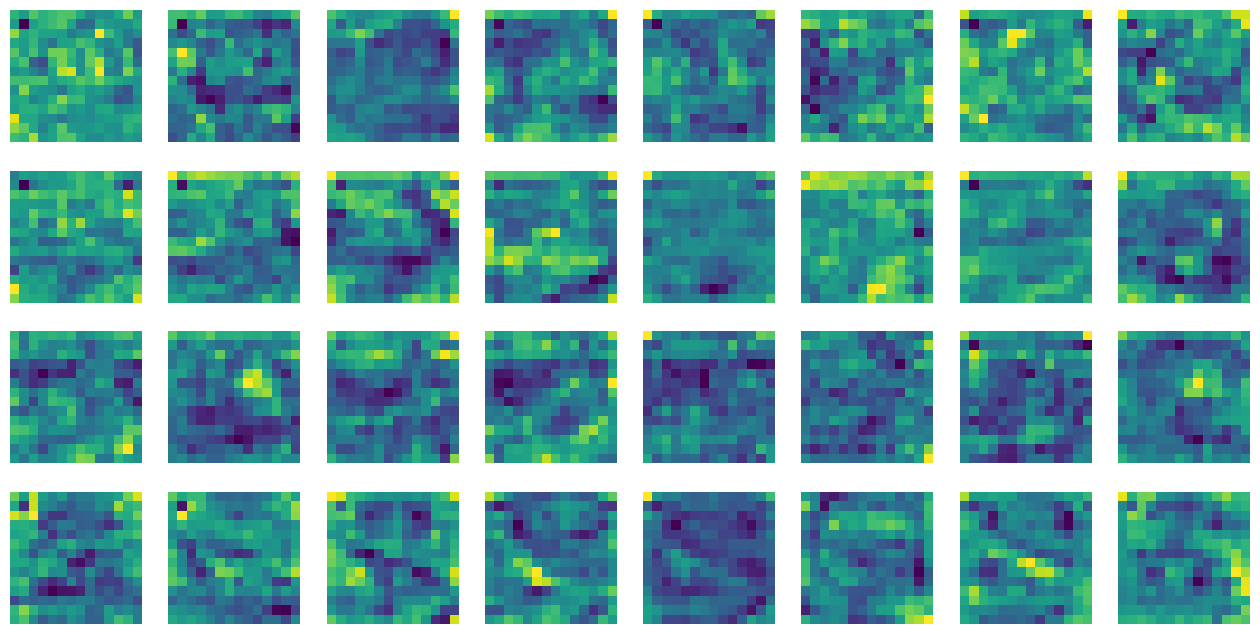

In [9]:
# Register hooks for more layers
resnet50.layer2[0].conv1.register_forward_hook(get_activation('layer2_conv1'))
resnet50.layer3[0].conv1.register_forward_hook(get_activation('layer3_conv1'))
resnet50.layer4[0].conv1.register_forward_hook(get_activation('layer4_conv1'))

# Forward pass through the network to get activations from other layers
output = resnet50(images)

print("Plot activation maps for layer2")
activation_maps_layer2 = activation['layer2_conv1']
plot_activation_maps(activation_maps_layer2, num_images=num_images_to_visualize, num_maps=num_feature_maps_to_visualize)

print("Plot activation maps for layer3")
activation_maps_layer3 = activation['layer3_conv1']
plot_activation_maps(activation_maps_layer3, num_images=num_images_to_visualize, num_maps=num_feature_maps_to_visualize)

print("Plot activation maps for layer4")
activation_maps_layer4 = activation['layer4_conv1']
plot_activation_maps(activation_maps_layer4, num_images=num_images_to_visualize, num_maps=num_feature_maps_to_visualize)
